# functions

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from keras.callbacks import EarlyStopping
from scipy.interpolate import griddata


import warnings
warnings.filterwarnings('ignore')

In [57]:
def load_data():

    dataset = datasets.load_digits()
    X = dataset.data
    y = dataset.target
    
    X = X/255.0
    X = X.reshape(-1, 8, 8, 1)

    return X, y

In [58]:
def get_train_test_split(X, y, test_size):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [59]:
def build_cnn(n_hidden_layers, n_filters):

    input_shape = (8, 8, 1)
    num_classes = 10

    model = tf.keras.models.Sequential()
    for _ in range(n_hidden_layers):
        model.add(tf.keras.layers.Conv2D(n_filters, kernel_size = (2, 2), activation='relu', input_shape=input_shape))
        #model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    #model.summary()

    return model

In [60]:
def train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, n_epochs=200, batch_size=32, patience=20, print_summary=True):

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )


    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


    history = model.fit(X_train,
                        y_train,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        verbose=0)


    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    
    if print_summary:
        plt.plot(figsize=(10, 6), dpi = 500)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        print(confusion_matrix(y_test, y_pred_classes))
        print(classification_report(y_test, y_pred_classes))
        print(f'Test accuracy: {test_acc}')
        print(f'Number of parameters: {model.count_params()}')

    n_params = model.count_params()

    return history, test_acc, n_params

In [96]:
def plot_3d_mesh_results(results_df):

    train_size = results_df['train_size']
    n_params = results_df['n_params']
    test_accuracy = results_df['test_accuracy']

    grid_x, grid_y = np.meshgrid(
        np.linspace(train_size.min(), train_size.max(), 100),
        np.linspace(n_params.min(), n_params.max(), 100)
    )
    grid_z = griddata(
        (train_size, n_params), test_accuracy, (grid_x, grid_y), method='linear'
    )

    fig = plt.figure(figsize=(12, 8), dpi = 300)
    ax = fig.add_subplot(111, projection='3d')

    surface = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)
    
    cbar = plt.colorbar(surface, ax=ax, pad=0.1)
    cbar.set_label('Test Accuracy', rotation=270, labelpad=15)

    ax.set_xlabel('Train Size')
    ax.set_ylabel('Number of Parameters (n_params)')
    ax.set_zlabel('Test Accuracy')
    ax.set_title('3D Mesh Grid of Results: Train Size, Parameters, and Test Accuracy')

    plt.show()

In [95]:
def plot_heatmap_results(results_df):
    train_size = results_df['train_size']
    n_params = results_df['n_params']
    test_accuracy = results_df['test_accuracy']

    grid_x, grid_y = np.meshgrid(
        np.linspace(train_size.min(), train_size.max(), 100),
        np.linspace(n_params.min(), n_params.max(), 100)
    )
    grid_z = griddata(
        (train_size, n_params), test_accuracy, (grid_x, grid_y), method='linear'
    )

    plt.figure(figsize=(12, 8), dpi=300)
    heatmap = plt.imshow(
        grid_z,
        extent=[n_params.min(), n_params.max(), train_size.min(), train_size.max()],
        origin='lower',
        cmap='viridis',
        aspect='auto'
    )
    
    cbar = plt.colorbar(heatmap, pad=0.1)
    cbar.set_label('Test Accuracy', rotation=270, labelpad=15)


    plt.xlabel('Number of Parameters (n_params)')
    plt.ylabel('Train Size')
    plt.title('Heatmap of Results: Train Size, Parameters, and Test Accuracy')

    plt.show()


# main

In [62]:
X, y = load_data()

***Build and train a simple convolutional neural network model (of one or two convolutional layers) to classify the images in the digits data set. Evaluate its performance***

In [63]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, test_size=0.2)

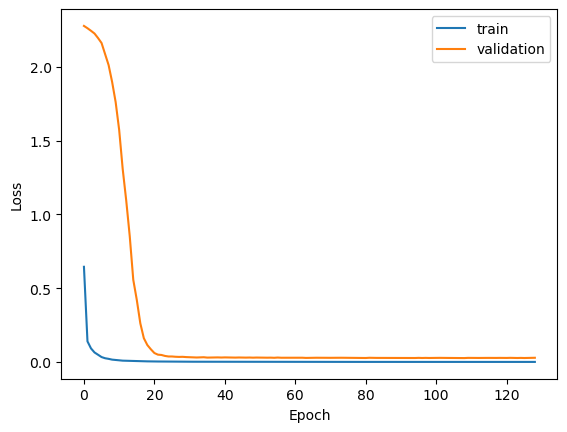

[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 46  1  0  0  0]
 [ 0  0  0  0  0  1 34  0  0  0]
 [ 0  0  0  0  0  0  0 34  0  0]
 [ 0  0  0  0  0  1  0  0 29  0]
 [ 0  0  0  0  0  0  0  0  0 40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        34
           4       1.00      1.00      1.00        46
           5       0.94      0.98      0.96        47
           6       0.97      0.97      0.97        35
           7       1.00      1.00      1.00        34
           8       1.00      0.97      0.98        30
           9       1.00      1.00      1.00        40

    accuracy                           0.99       360
   macro avg       

(<keras.src.callbacks.history.History at 0x7fc4cf5d4310>,
 0.9888888597488403,
 16074)

In [64]:
n_hidden_layers = 2
n_filters = 32

model = build_cnn(n_hidden_layers=n_hidden_layers, n_filters=n_filters)
train_model(model, X_train, y_train, X_val, y_val, X_test, y_test)

***Investigate the performance of the convolutional neural network in terms of the size
of the training data and the design of the layers. Try to find a network with as few
parameters as possible, without sacrificing performance***

In [65]:
def run_experiment(X, y, n_hidden_layers, n_filters, train_sizes):

    result_dataframe = pd.DataFrame()
    
    
    train_X, X_test, train_y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    for train_size in train_sizes:
        
        test_size = 1 - train_size
        
        X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=test_size, random_state=42)
        
        train_samples = X_train.shape[0]
        
        for n_hidden_layer in n_hidden_layers:
            for n_filter in n_filters:
                    
                    model = build_cnn(n_hidden_layer, n_filter)

                    history, test_accuracy, n_params = train_model(
                        model, X_train, y_train, X_val, y_val, X_test, y_test, print_summary=False
                    )
                    
                    new_row = pd.DataFrame({
                        'train_size': [train_samples],
                        'n_params': [n_params],
                        'n_hidden_layers': [n_hidden_layer],
                        'n_filters': [n_filter],
                        'test_accuracy': [test_accuracy]
                    })
                    
                    result_dataframe = pd.concat([result_dataframe, new_row], ignore_index=True)
                    
                    print('-' * 70)
                    print(new_row)
    
    return result_dataframe


In [68]:
train_sizes = np.linspace(0.5, 0.9, 4)
n_hidden_layers = np.arange(1, 6)
n_filters = np.arange(16, 65, 16)

In [69]:
result_dataframe = run_experiment(X, y, n_hidden_layers, n_filters, train_sizes)

----------------------------------------------------------------------
   train_size  n_params  n_hidden_layers  n_filters  test_accuracy
0         718      7994                1         16       0.947222
----------------------------------------------------------------------
   train_size  n_params  n_hidden_layers  n_filters  test_accuracy
0         718     15978                1         32       0.958333
----------------------------------------------------------------------
   train_size  n_params  n_hidden_layers  n_filters  test_accuracy
0         718     23962                1         48       0.952778
----------------------------------------------------------------------
   train_size  n_params  n_hidden_layers  n_filters  test_accuracy
0         718     31946                1         64       0.958333
----------------------------------------------------------------------
   train_size  n_params  n_hidden_layers  n_filters  test_accuracy
0         718      7018                2  

In [ ]:
result_dataframe

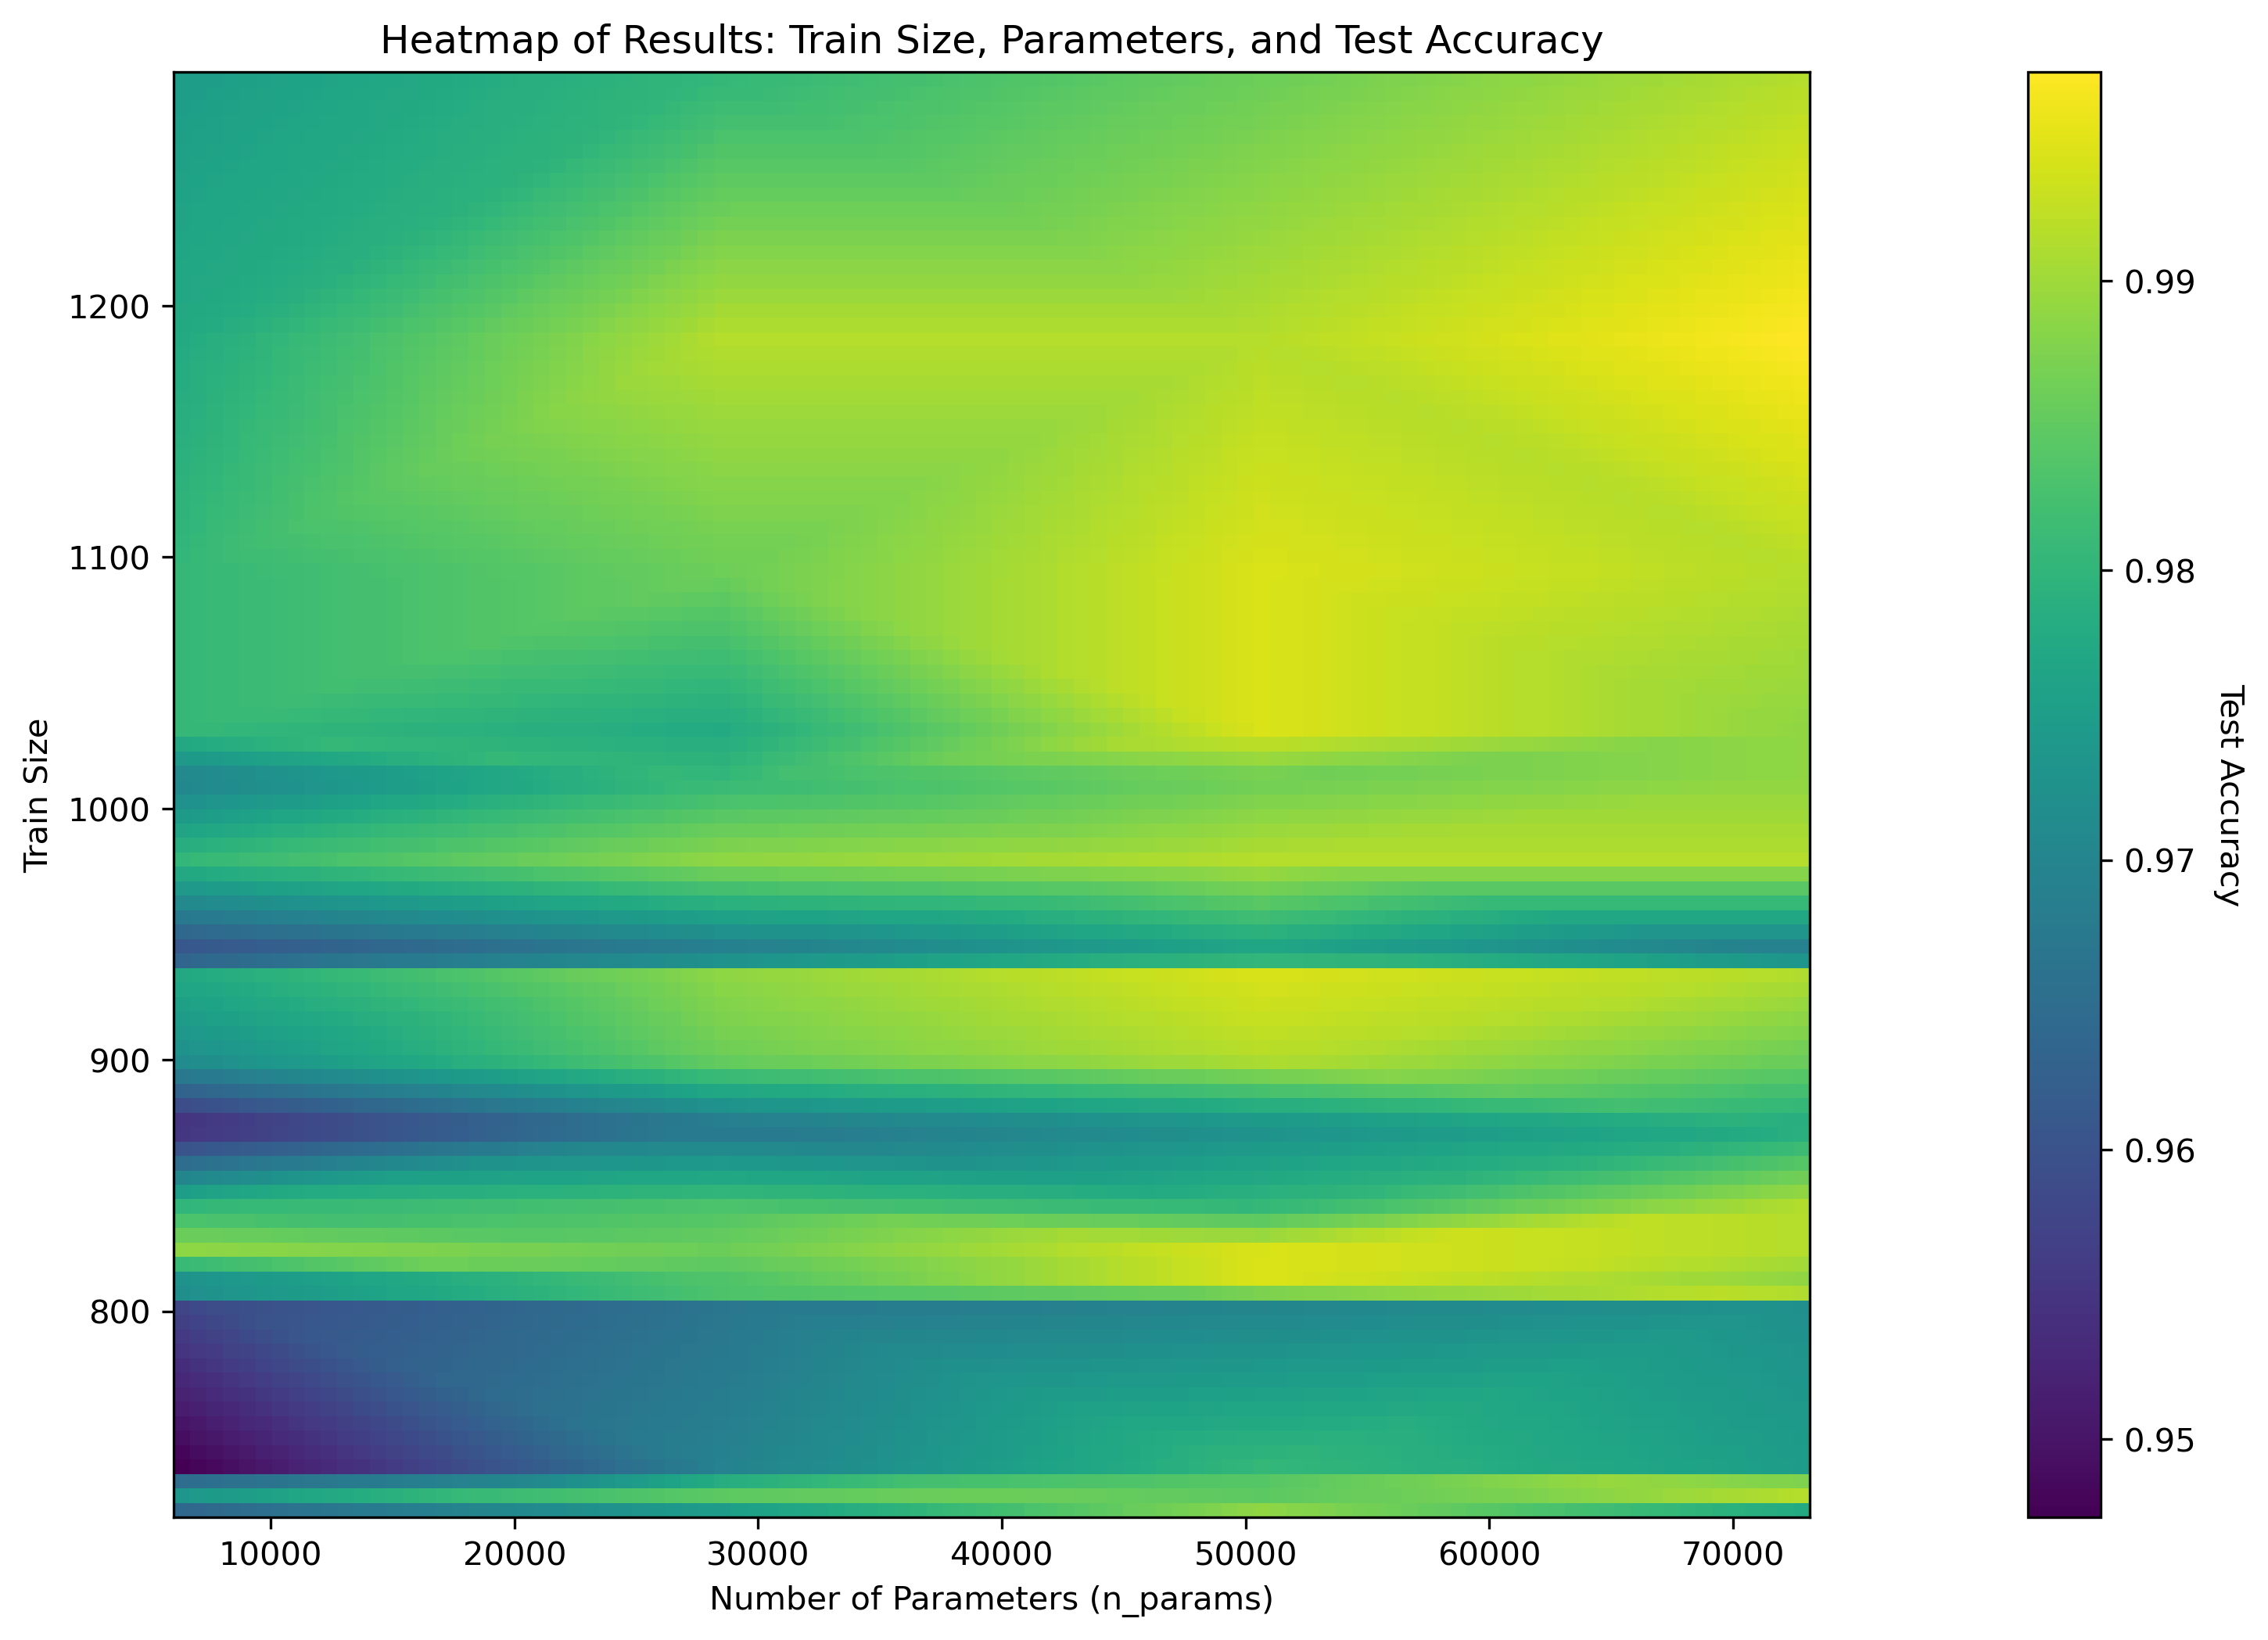

In [97]:
plot_heatmap_results(result_dataframe)

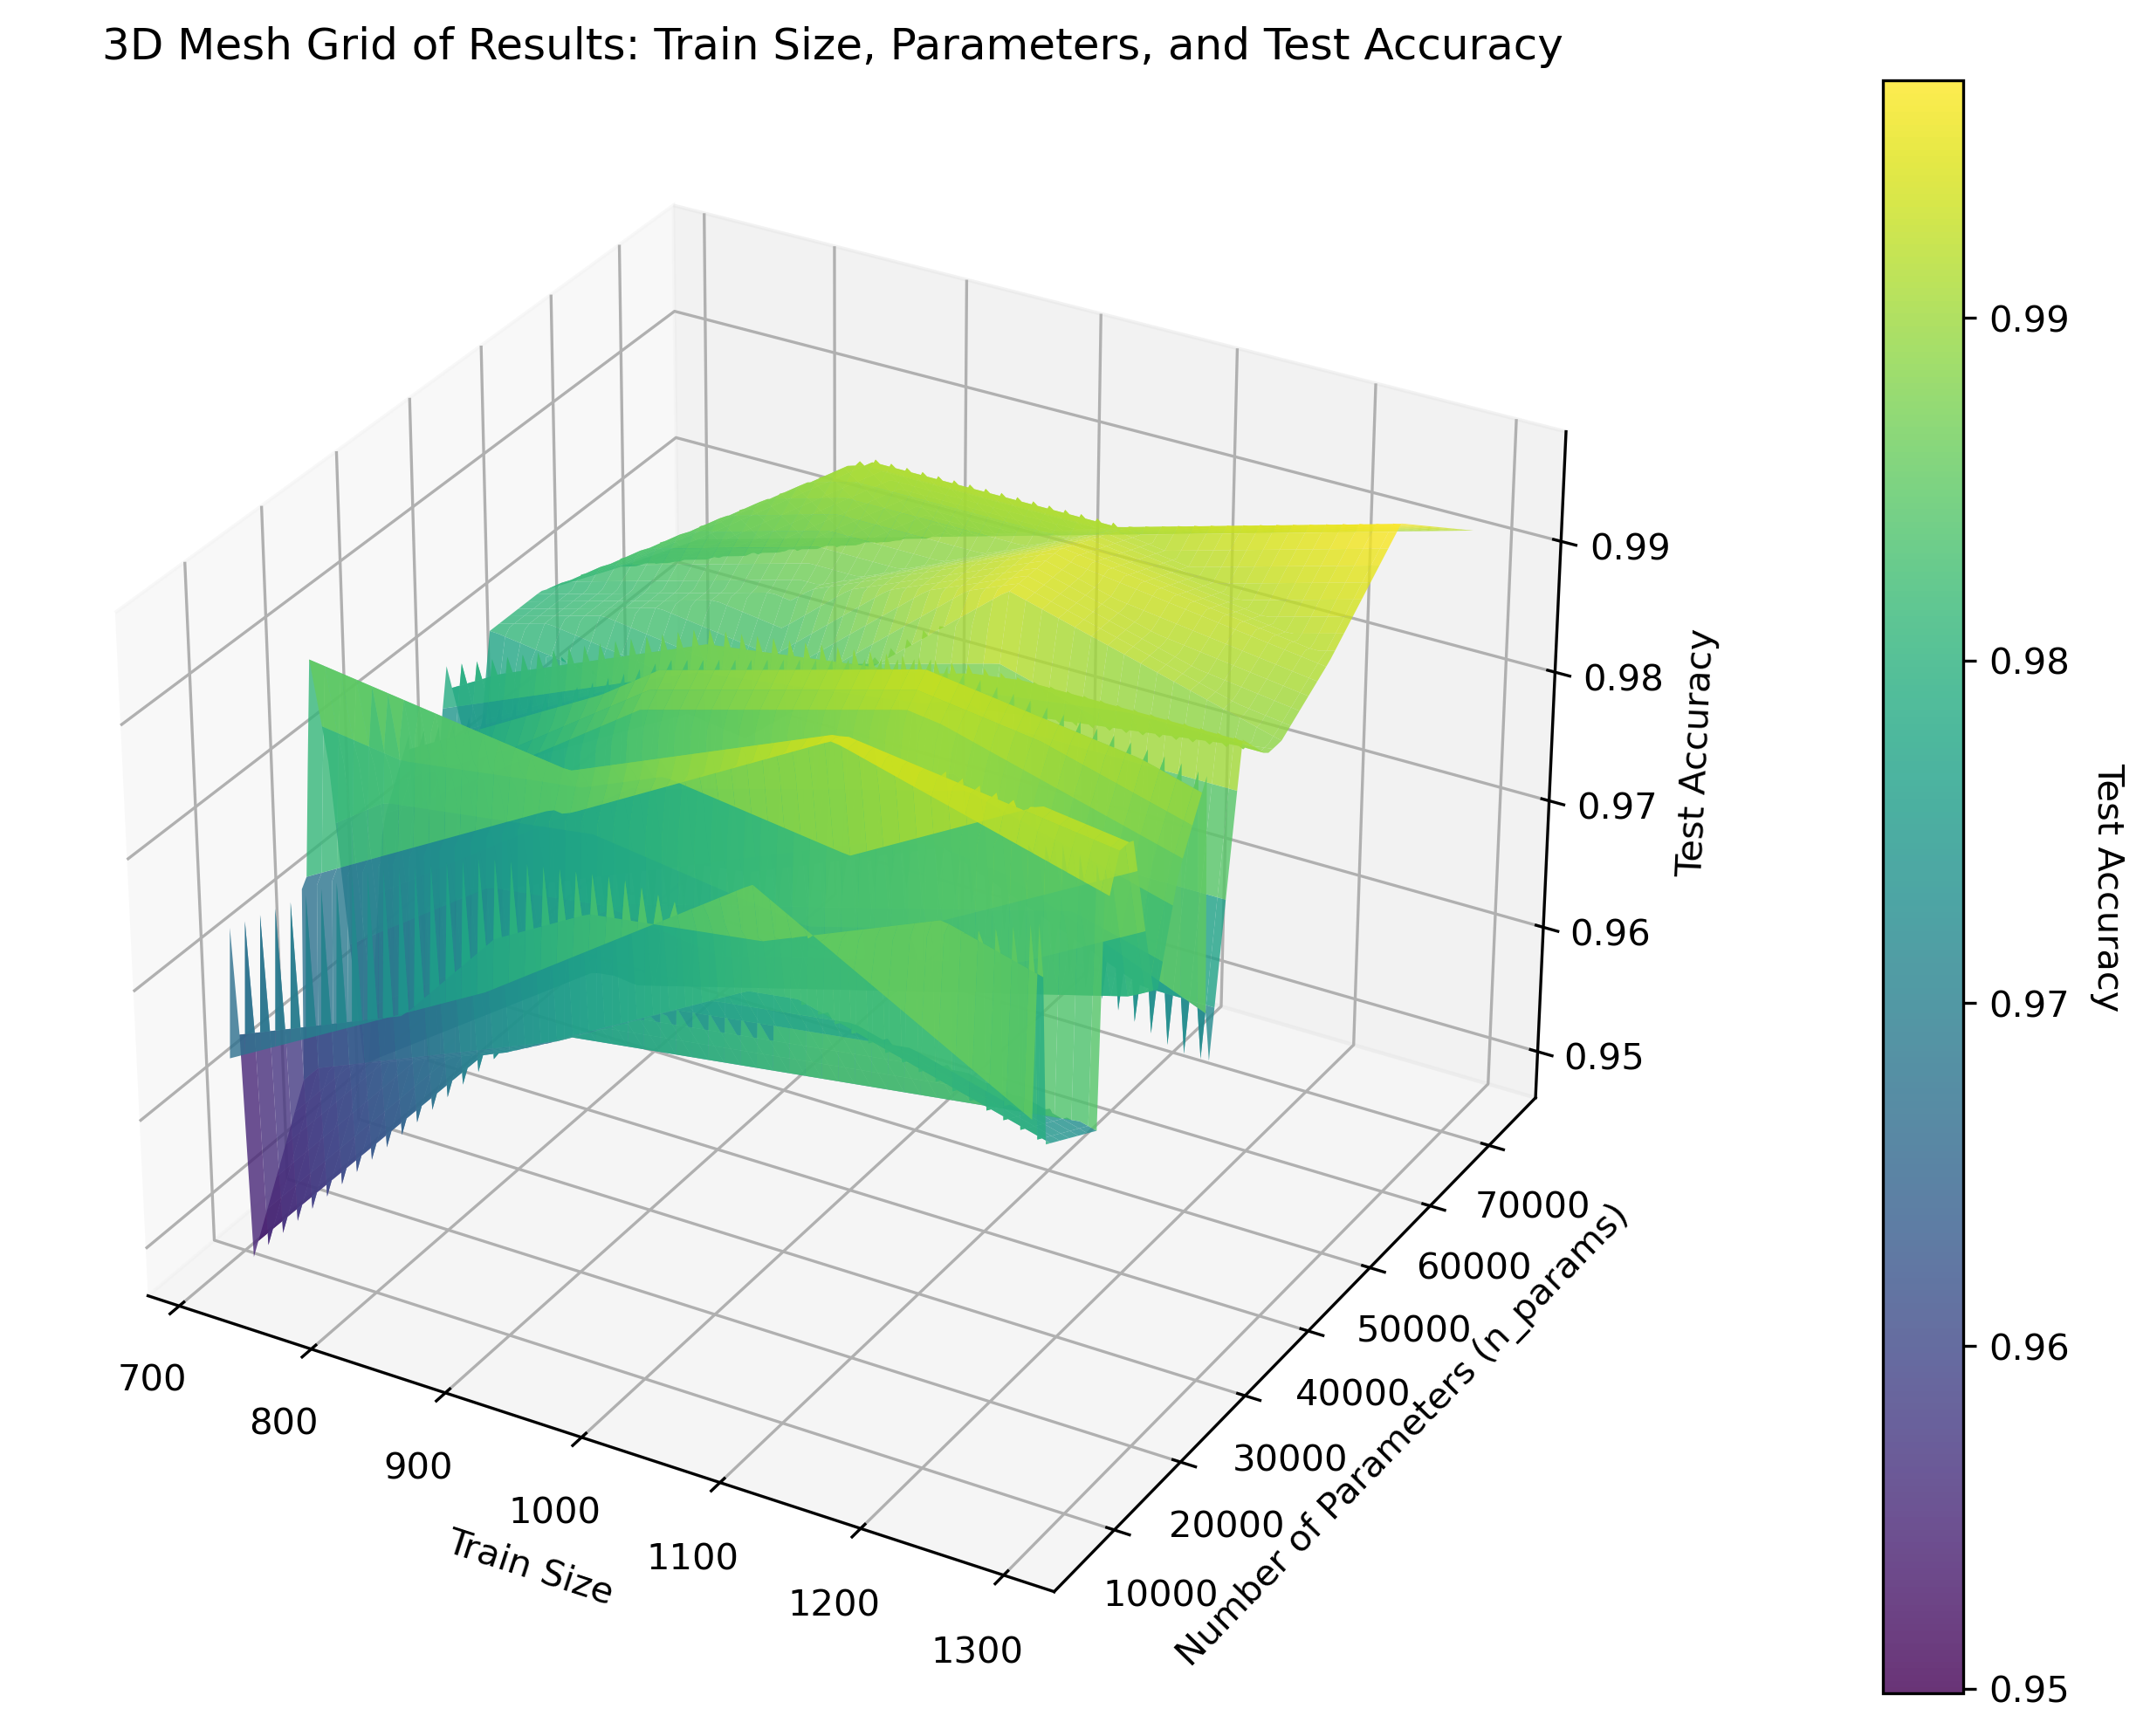

In [98]:
plot_3d_mesh_results(result_dataframe)

In [83]:
result_dataframe.to_csv('results_ex3.csv', index=False)

***Try to implement a convolutional neural network classifier on a more complex
dataset***

In [ ]:
def train_model_mnist(model, X_train, y_train, X_val, y_val, X_test, y_test, n_epochs=500, batch_size=32, patience=10, print_summary=True):

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )


    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


    history = model.fit(X_train,
                        y_train,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])


    test_loss, test_acc = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    
    if print_summary:
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.legend()
        plt.show()
        print(confusion_matrix(y_test, y_pred_classes))
        print(classification_report(y_test, y_pred_classes))
        print('Test Accuracy:', test_acc)

    n_params = model.count_params()

    return history, test_acc, n_params

In [ ]:
def build_cnn_mnist():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())  
        
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())  
    
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling2D())
    model.add(tf.keras.layers.BatchNormalization())  
    
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.summary()
    return model


In [ ]:
def plot_misclassified_images(model, X_test, y_test, class_names, max_images=25):

    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)

    misclassified_indices = np.where(y_pred_classes != y_test)[0]

    if len(misclassified_indices) == 0:
        print("No misclassified instances.")
        return

    misclassified_indices = misclassified_indices[:max_images]

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(misclassified_indices):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred_classes[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)

    plt.tight_layout()
    plt.show()


In [84]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train/255.0
X_test = X_test/255.0

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [88]:
model = build_cnn_mnist()

Model: "sequential_292"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_857 (Conv2D)             │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_857         │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_858 (Conv2D)             │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_858         │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_859 (Conv2D)             │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_859         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_294 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,986 (402.29 KB)

 Trainable params: 102,538 (400.54 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - accuracy: 0.9267 - loss: 0.2420 - val_accuracy: 0.9807 - val_loss: 0.0603
Epoch 2/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9870 - loss: 0.0428 - val_accuracy: 0.9867 - val_loss: 0.0445
Epoch 3/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.9892 - loss: 0.0327 - val_accuracy: 0.9886 - val_loss: 0.0387
Epoch 4/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 51s 34ms/step - accuracy: 0.9925 - loss: 0.0243 - val_accuracy: 0.9884 - val_loss: 0.0412
Epoch 5/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 51s 34ms/step - accuracy: 0.9931 - loss: 0.0218 - val_accuracy: 0.9900 - val_loss: 0.0387
Epoch 6/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 49s 33ms/step - accuracy: 0.9950 - loss: 0.0162 - val_accuracy: 0.9906 - val_loss: 0.0344
Epoch 7/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 62s 41ms/step - accuracy: 0.9951 - loss: 0.0137 - val_accuracy: 0.9901 - val_loss: 0.0371
Epoch 8/500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 56s 37ms/step - accuracy: 

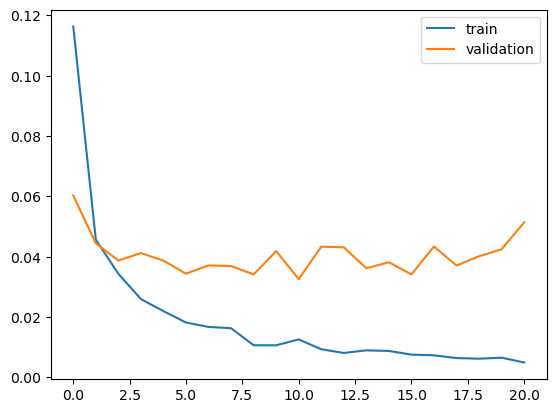

[[ 977    0    0    0    0    0    2    1    0    0]
 [   1 1131    0    1    0    0    1    1    0    0]
 [   1    1 1022    0    1    0    0    7    0    0]
 [   0    0    1 1004    0    3    0    1    1    0]
 [   0    0    0    0  970    0    2    0    0   10]
 [   0    0    0    6    0  885    1    0    0    0]
 [   3    3    0    1    3    5  943    0    0    0]
 [   0    2    0    2    0    0    0 1021    0    3]
 [   0    1    0    2    0    1    0    1  965    4]
 [   0    0    0    1    5    3    0    5    0  995]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.99   

In [99]:
history = train_model_mnist(model, X_train, y_train, X_val, y_val, X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


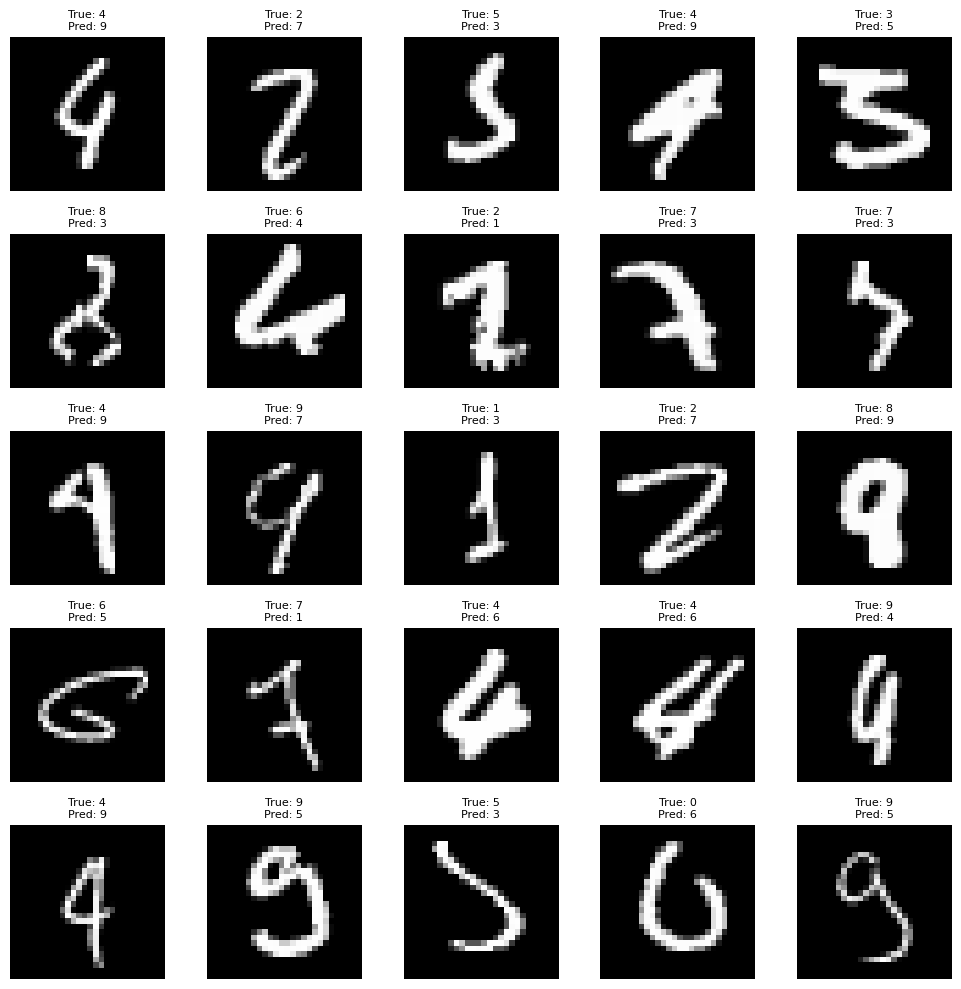

In [102]:
class_names = [str(i) for i in range(10)] 
plot_misclassified_images(model, X_test, y_test, class_names)